In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
     Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar100, cifar10

In [11]:
(train_data_original, _), (test_data_original, _) = cifar100.load_data(label_mode='fine')

In [12]:
train_data_original = train_data_original.astype('float32') / 255.
test_data_original = test_data_original.astype('float32') / 255.

Adding Noise to the dataseet

In [13]:
# Gaussian Noise
def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data

In [14]:
train_data_noisy = add_noise_and_clip_data(train_data_original)
test_data_noisy = add_noise_and_clip_data(test_data_original)

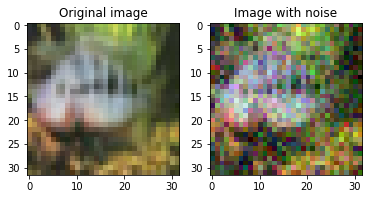

In [15]:
idx = 4
plt.subplot(1,2,1)
plt.imshow(train_data_original[idx])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_data_noisy[idx])
plt.title('Image with noise')
plt.show()

Convoluting the dataset


In [32]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

Deconvoluting the dataset

In [33]:
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

Denoising the dataset

In [34]:
def denoising_autoencoder():
      dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
      conv_block1 = conv_block(dae_inputs, 32, 3)
      conv_block2 = conv_block(conv_block1, 64, 3)
      conv_block3 = conv_block(conv_block2, 128, 3)
      conv_block4 = conv_block(conv_block3, 256, 3)
      conv_block5 = conv_block(conv_block4, 256, 3, 1)

      deconv_block1 = deconv_block(conv_block5, 256, 3)
      merge1 = Concatenate()([deconv_block1, conv_block3])
      
      deconv_block2 = deconv_block(merge1, 128, 3)
      merge2 = Concatenate()([deconv_block2, conv_block2])
      
      deconv_block3 = deconv_block(merge2, 64, 3)
      merge3 = Concatenate()([deconv_block3, conv_block1])
      
      deconv_block4 = deconv_block(merge3, 32, 3)

      final_deconv = Conv2DTranspose(filters=3,
                                      kernel_size=3,
                                      padding='same')(deconv_block4)
      dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
      
      return Model(dae_inputs, dae_outputs, name='dae')

In [37]:

dae = denoising_autoencoder()
dae.compile(loss='mse', optimizer='adam')
  
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
  
dae.fit(train_data_noisy,
      train_data_original,
      validation_data=(test_data_noisy, test_data_original),
      epochs=10,
      batch_size=128,
      callbacks=[checkpoint])

Epoch 1/10
389/391 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 00001: val_loss improved from inf to 0.00477, saving model to best_model.h5
391/391 [==============================] - 12s 32ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.0026
Epoch 00002: val_loss improved from 0.00477 to 0.00344, saving model to best_model.h5
391/391 [==============================] - 12s 31ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.0024
Epoch 00003: val_loss improved from 0.00344 to 0.00223, saving model to best_model.h5
391/391 [==============================] - 12s 31ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 4/10
391/391 [==============================] - ETA: 0s - loss: 0.0023
Epoch 00004: val_loss improved from 0.00223 to 0.00220, saving model to best_model.h5
391/391 [==============================] - 12s 31ms/step - loss: 0.0023 - val_l

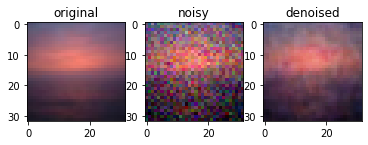

In [42]:
#dae.load_weights('best_model.h5')
test_data_denoised = dae.predict(test_data_noisy)
idx = 4
plt.subplot(1,3,1)
plt.imshow(test_data_original[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_data_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.show()